<a href="https://colab.research.google.com/github/sagawritescode/ERAAssignment10/blob/main/ERA_V1_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sagawritescode/ERAAssignment10.git

Cloning into 'ERAAssignment10'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 72 (delta 41), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (72/72), 17.29 KiB | 1.08 MiB/s, done.


In [2]:
from ERAAssignment10.dataloader import Cifar10SearchDataset

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
from ERAAssignment10.transforms import CustomResnetTransforms
from ERAAssignment10.dataloader import Cifar10SearchDataset

In [5]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

In [6]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12552804.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


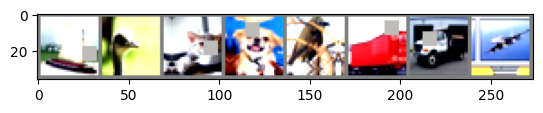

ship  bird  cat   dog  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
from ERAAssignment10.model import CustomResNet
from ERAAssignment10.utils import print_summary, get_lr, get_device

In [10]:
device = get_device()
model = CustomResNet("bn").to(device)
print_summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [11]:
from ERAAssignment10.train import train, test

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


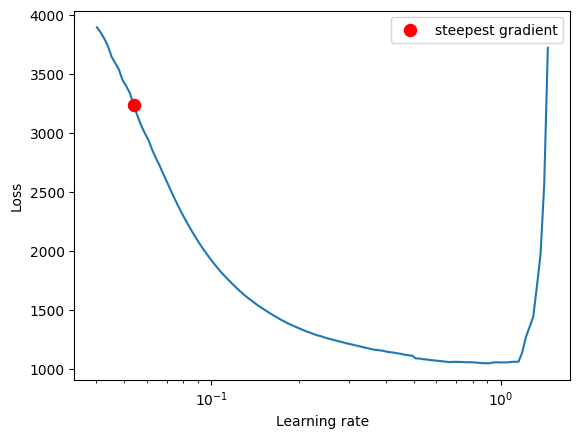

In [12]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [13]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=5.38E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Epoch=0 Loss=355.73187255859375 LR=0.011212184049079756 Batch_id=97 Accuracy=48.61: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]



Test set: Average loss: 1.5385, Accuracy: 5056/10000 (50.56%)

EPOCH: 1


Epoch=1 Loss=310.3156433105469 LR=0.02188636809815951 Batch_id=97 Accuracy=64.33: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]



Test set: Average loss: 1.5449, Accuracy: 5736/10000 (57.36%)

EPOCH: 2


Epoch=2 Loss=278.63397216796875 LR=0.03256055214723926 Batch_id=97 Accuracy=71.38: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.7565, Accuracy: 7428/10000 (74.28%)

EPOCH: 3


Epoch=3 Loss=260.0733947753906 LR=0.04323473619631902 Batch_id=97 Accuracy=77.69: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 1.0001, Accuracy: 7140/10000 (71.40%)

EPOCH: 4


Epoch=4 Loss=172.15667724609375 LR=0.053771109226638025 Batch_id=97 Accuracy=79.95: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.7291, Accuracy: 7484/10000 (74.84%)

EPOCH: 5


Epoch=5 Loss=134.2232208251953 LR=0.05093981343716434 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.7468, Accuracy: 7616/10000 (76.16%)

EPOCH: 6


Epoch=6 Loss=170.9170379638672 LR=0.048108517647690655 Batch_id=97 Accuracy=84.39: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]



Test set: Average loss: 0.5156, Accuracy: 8305/10000 (83.05%)

EPOCH: 7


Epoch=7 Loss=137.58497619628906 LR=0.04527722185821697 Batch_id=97 Accuracy=85.93: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.5186, Accuracy: 8367/10000 (83.67%)

EPOCH: 8


Epoch=8 Loss=123.07496643066406 LR=0.042445926068743284 Batch_id=97 Accuracy=87.23: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.5025, Accuracy: 8407/10000 (84.07%)

EPOCH: 9


Epoch=9 Loss=109.12909698486328 LR=0.039614630279269605 Batch_id=97 Accuracy=88.55: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]



Test set: Average loss: 0.5743, Accuracy: 8284/10000 (82.84%)

EPOCH: 10


Epoch=10 Loss=120.31126403808594 LR=0.03678333448979591 Batch_id=97 Accuracy=89.08: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.5592, Accuracy: 8304/10000 (83.04%)

EPOCH: 11


Epoch=11 Loss=76.49788665771484 LR=0.033952038700322235 Batch_id=97 Accuracy=90.32: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.3969, Accuracy: 8748/10000 (87.48%)

EPOCH: 12


Epoch=12 Loss=87.35979461669922 LR=0.03112074291084855 Batch_id=97 Accuracy=91.18: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.4720, Accuracy: 8614/10000 (86.14%)

EPOCH: 13


Epoch=13 Loss=72.54073333740234 LR=0.028289447121374864 Batch_id=97 Accuracy=91.69: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.3694, Accuracy: 8834/10000 (88.34%)

EPOCH: 14


Epoch=14 Loss=79.99114227294922 LR=0.025458151331901182 Batch_id=97 Accuracy=92.64: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 0.3703, Accuracy: 8876/10000 (88.76%)

EPOCH: 15


Epoch=15 Loss=71.73462677001953 LR=0.0226268555424275 Batch_id=97 Accuracy=93.30: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]



Test set: Average loss: 0.3324, Accuracy: 8994/10000 (89.94%)

EPOCH: 16


Epoch=16 Loss=51.221500396728516 LR=0.019795559752953815 Batch_id=97 Accuracy=94.21: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 0.3524, Accuracy: 8941/10000 (89.41%)

EPOCH: 17


Epoch=17 Loss=44.17643356323242 LR=0.016964263963480122 Batch_id=97 Accuracy=95.05: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.3298, Accuracy: 9069/10000 (90.69%)

EPOCH: 18


Epoch=18 Loss=51.93223571777344 LR=0.014132968174006444 Batch_id=97 Accuracy=95.74: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.3176, Accuracy: 9074/10000 (90.74%)

EPOCH: 19


Epoch=19 Loss=44.78883743286133 LR=0.011301672384532759 Batch_id=97 Accuracy=96.07: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.3213, Accuracy: 9114/10000 (91.14%)

EPOCH: 20


Epoch=20 Loss=35.19868850708008 LR=0.008470376595059073 Batch_id=97 Accuracy=96.81: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.2984, Accuracy: 9195/10000 (91.95%)

EPOCH: 21


Epoch=21 Loss=23.954055786132812 LR=0.005639080805585388 Batch_id=97 Accuracy=97.19: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.2859, Accuracy: 9213/10000 (92.13%)

EPOCH: 22


Epoch=22 Loss=25.89458465576172 LR=0.0028077850161117093 Batch_id=97 Accuracy=97.77: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 0.2762, Accuracy: 9249/10000 (92.49%)

EPOCH: 23


Epoch=23 Loss=8.531848907470703 LR=-2.3510773361976045e-05 Batch_id=97 Accuracy=98.19: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.2729, Accuracy: 9274/10000 (92.74%)

